# Independent RNN Example

## Data Preprocessing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import pandas as pd
#Functional coding
import functools
from functools import partial
from tensorflow.python.ops import array_ops
from tensorflow.contrib import rnn
from tensorflow.contrib import layers
from tqdm import tqdm

In [2]:
class_names = ['alt.atheism',
                 'comp.graphics',
                 'comp.os.ms-windows.misc',
                 'comp.sys.ibm.pc.hardware',
                 'comp.sys.mac.hardware',
                 'comp.windows.x',
                 'misc.forsale',
                 'rec.autos',
                 'rec.motorcycles',
                 'rec.sport.baseball',
                 'rec.sport.hockey',
                 'sci.crypt',
                 'sci.electronics',
                 'sci.med',
                 'sci.space',
                 'soc.religion.christian',
                 'talk.politics.guns',
                 'talk.politics.mideast',
                 'talk.politics.misc',
                 'talk.religion.misc']

In [3]:
def print_confusion_matrix(confusion_matrix, class_names, 
                           figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6b')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 2500
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
RNN_DIM = 100
CLASS_DIM = 20
VALIDATION_SPLIT = 0.4

In [6]:
def get_data(data_path):
    texts = []  # list of text samples
    labels_index = {}  # dictionary mapping label name to numeric id
    labels = []  # list of label ids
    for name in sorted(os.listdir(data_path)):
        path = os.path.join(data_path, name)
        if os.path.isdir(path):
            label_id = len(labels_index)
            labels_index[name] = label_id
            for fname in sorted(os.listdir(path)):
                if fname.isdigit():
                    fpath = os.path.join(path, fname)
                    args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                    with open(fpath, **args) as f:
                        t = f.read()
                        i = t.find('\n\n')  # skip header
                        if 0 < i:
                            t = t[i:]
                        texts.append(t)
                    labels.append(label_id)
    return texts, labels_index, labels

In [7]:
texts, labels_index, labels = get_data(TEXT_DATA_DIR)

In [8]:
indices = np.arange(len(texts))
np.random.shuffle(indices)
num_validation_samples = int(VALIDATION_SPLIT * len(texts))

In [9]:
def data_preprocessing(texts, labels, indices, num_validation_samples, classifier="NeuralNetwork"):
    
    word_index = None
    
    if classifier == "NeuralNetwork":
        tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
        tokenizer.fit_on_texts(texts)
        sequences = tokenizer.texts_to_sequences(texts)
        
        plt.figure()
        plt.hist([len(x) for x in sequences])
        plt.xlabel('Length of Document')
        plt.ylabel('Number of Documents')
        plt.title('Statistic of Data')
        plt.grid(True)
        plt.show()
        
        word_index = tokenizer.word_index
        
        with open('tokenizer.pickle', 'wb') as handle:
            pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
        
    else:
        vectorizer = TfidfVectorizer()
        data = vectorizer.fit_transform(texts)
    
    labels = to_categorical(np.asarray(labels))  
    data = data[indices]
    labels = labels[indices]

    x_train = data[:-num_validation_samples]
    y_train = labels[:-num_validation_samples]
    x_val = data[-num_validation_samples:]
    y_val = labels[-num_validation_samples:]
    
    return x_train, y_train, x_val, y_val, word_index

In [10]:
from keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, GRU, Concatenate, Dropout
from keras.models import Model
from keras import backend as K

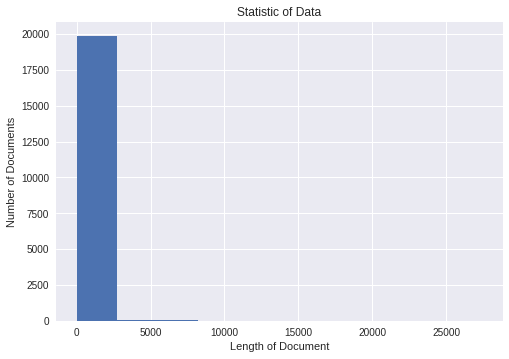

In [11]:
x_train, y_train, x_val, y_val, word_index = data_preprocessing(texts, 
                                                                labels, 
                                                                indices, 
                                                                num_validation_samples, 
                                                                classifier="NeuralNetwork")

In [12]:
def get_embedding_matrix(word_index):
    
    embeddings_index = {}
    with open(os.path.join(GLOVE_DIR, 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM))) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, num_words

In [13]:
embedding_matrix, num_words = get_embedding_matrix(word_index)

# Independent RNN Cell

In [14]:
class IndCell(tf.nn.rnn_cell.RNNCell):

    def __init__(self, num_state_units, num_input_units):
        self.num_state_units = num_state_units
        self.w = self.weight_variable([num_input_units, self.num_state_units], 'w')
        self.u = self.weight_variable([self.num_state_units], 'u')
        self.b = self.bias_variable([self.num_state_units], 'b')


    @property
    def state_size(self):
        return self.num_state_units

    @property
    def output_size(self):
        return self.num_state_units

    def __call__(self, inputs, state, scope=None):
        
        with tf.variable_scope(scope or type(self).__name__):
            
            encoded = tf.matmul(inputs, self.w)
            state = state*self.u
            next_state = tf.nn.relu(encoded + state + self.b)

            return next_state, next_state
        
    
    # Weight constructing function
    @staticmethod
    def weight_variable(shape, name="w"):
        initial = tf.truncated_normal(shape, stddev=0.0001)
        return tf.Variable(initial, name=name)

    # Bias constructing function
    @staticmethod
    def bias_variable(shape, name="b"):
        initial = tf.constant(0., shape=shape)
        return tf.Variable(initial, name=name)

In [15]:
indcell = IndCell(10, 30)

In [16]:
initial_state = indcell.zero_state(100, dtype=tf.float32)

In [17]:
a = tf.Variable(tf.truncated_normal(shape=[100, 30],mean=0.0, stddev=1.0),name="action")

In [18]:
indcell(a, initial_state, scope='cell_test')

(<tf.Tensor 'cell_test/Relu:0' shape=(100, 10) dtype=float32>,
 <tf.Tensor 'cell_test/Relu:0' shape=(100, 10) dtype=float32>)

# Tensorflow RNN Classifier

In [19]:
class RNNClassifier(object):
    def __init__(self, input_dim, embedding_dim, rnn_dim, 
                 class_dim, timesteps, embedding_matrix, 
                 learning_rate=0.001):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.rnn_dim = rnn_dim
        self.class_dim = class_dim
        self.timesteps = timesteps
        self.learning_rate = learning_rate
        self.create_graph(embedding_matrix)        
        self._sesh = tf.Session()
        init = tf.global_variables_initializer()
        self._sesh.run(init)
        
    
    def create_graph(self, embedding_matrix):
        self.X = tf.placeholder(tf.int32, [None, self.timesteps])
        self.Y = tf.placeholder(tf.float32, [None, self.class_dim])
        with tf.variable_scope("Embedding"):
            glove_weights_initializer = tf.constant_initializer(embedding_matrix)
            embedding_weights = tf.get_variable(name='embedding_weights', 
                                                shape=embedding_matrix.shape, 
                                                initializer=glove_weights_initializer,
                                                trainable=False)
            embed = tf.nn.embedding_lookup(embedding_weights, self.X)
        with tf.variable_scope("RNN"):
            indcell = IndCell(self.rnn_dim, self.embedding_dim)
            initial_state = indcell.zero_state(64, dtype=tf.float32)
            outputs, states = tf.nn.dynamic_rnn(indcell, embed, dtype=tf.float32, initial_state=initial_state)
        with tf.variable_scope("Dense"):
            fc = layers.fully_connected(states, 500, scope='fc-01')
            logits = layers.fully_connected(states, self.class_dim, scope='fc-02', activation_fn=None)
            
        self.prediction = tf.nn.softmax(logits)
            
        with tf.variable_scope("Loss"):
            self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                    logits=logits, labels=self.Y))
            optimizer = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate)
            self.train_op = optimizer.minimize(self.loss_op)   
            
    @staticmethod        
    def next_batch(num, data, labels):
        '''
        Return a total of `num` random samples and labels. 
        '''
        idx = np.arange(0 , len(data))
        np.random.shuffle(idx)
        idx = idx[:num]
        data_shuffle = [data[ i] for i in idx]
        labels_shuffle = [labels[ i] for i in idx]

        return np.asarray(data_shuffle), np.asarray(labels_shuffle)
        
        
    
    def update(self, X, Y, batch_size, epochs=1):

        tbar = tqdm(range(epochs))
        for i in tbar:
            x,y = self.next_batch(batch_size,X,Y)
            _, loss = self._sesh.run([self.train_op, self.loss_op],
                                     feed_dict={self.X: x, self.Y: y}
                                    )

            s = "Loss: {:.4f}".format(loss)
            tbar.set_description(s)
        

In [ ]:
tf.reset_default_graph()
clf = RNNClassifier(MAX_NUM_WORDS, EMBEDDING_DIM, RNN_DIM, CLASS_DIM, MAX_SEQUENCE_LENGTH, embedding_matrix)

In [ ]:
clf.update(x_train, y_train, 64, 100000)

Loss: 2.9952:   0%|          | 24/100000 [00:10<11:54:23,  2.33it/s]

In [ ]:

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [ ]:
show_graph(tf.get_default_graph().as_graph_def())